<p style="font-family: Arial; font-size:3.75em;color:purple; font-style:bold"><br>
REGRESION LINEAL</p><br>

Objetivo:
- Predecir la frecuencia de uso semanal de **UNA ESTACIÓN** , usando como referencia los datos del  **AÑO 2018**.

In [1]:
#funciones y clases particulares al caso de estudio
from localpacks.data import get_data

#datasets
import numpy as np
import pandas as pd

#graficos
import matplotlib.pyplot as plt
import seaborn as sns

#models tools
from sklearn.model_selection import train_test_split

#performance
from sklearn.model_selection import GridSearchCV

#modelos
from sklearn.ensemble import RandomForestRegressor

## Definimos nuestro - df

In [2]:
df_get = get_data(year=2018, apply_format=True) #obtenemos nuestro df con el formato adecuado

In [65]:
df = df_get.copy() #hacemos una copia, para hacer pruebas rapidas, luego esta línea puede ser borrada

In [66]:
df.head(3)

,usuario_id,origen_nombre,origen_id,destino_nombre,destino_id,usuario_genero,usario_edad,tiempo_uso(s)
bici_fecha_hora_retiro,,,,,,,,
2018-01-01 00:08:05,5453,Uruguay,45,Virrey Cevallos,183,M,45,1193
2018-01-01 00:18:05,673,Posadas,189,Guardia Vieja,110,M,61,1579
2018-01-01 00:20:14,179119,Hospital Rivadavia,50,Padilla,31,F,52,1659


#### 1. Escogemos una estación

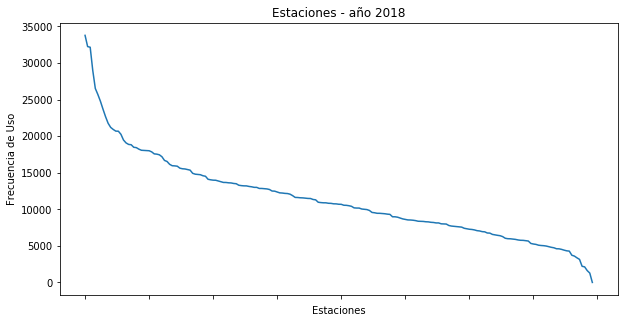

In [67]:
#df['origen_id'].value_counts().sort_values(ascending=False).plot() chequear, ¿porqué el gráfico se vpe distinto?

df['origen_nombre'].value_counts().plot(figsize=(10,5))

plt.title('Estaciones - año 2018')
plt.xlabel('Estaciones')
plt.ylabel('Frecuencia de Uso');

In [6]:
df['origen_nombre'].value_counts()[:3] #filtramos las 3 primeras

Facultad de Medicina    33776
Pacífico                32244
Parque Las Heras        32151
Name: origen_nombre, dtype: int64

Podemos observar que `Facultad de Medicina` es la que tiene la **mayor frecuencia de uso**, es la que usaremos como ejemplo.

In [7]:
df = df[df['origen_nombre'] == 'Facultad de Medicina']

In [8]:
df.shape #verificamos

(33776, 8)

#### 2. Escogemos un mes

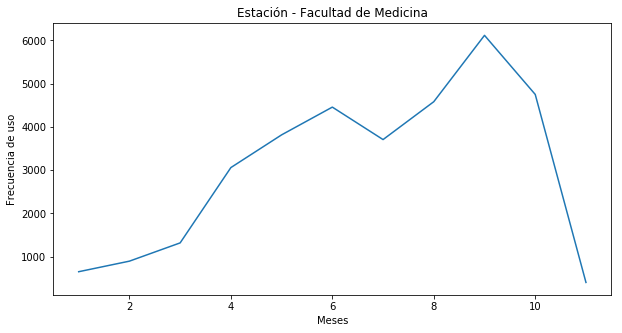

In [9]:
df.groupby(df.index.month)['origen_nombre'].count().plot(figsize=(10,5));
plt.title('Estación - Facultad de Medicina')
plt.ylabel('Frecuencia de uso')
plt.xlabel('Meses');

In [10]:
df.groupby(df.index.month)['origen_nombre'].count().sort_values(ascending=False)[:3]  

bici_fecha_hora_retiro
9     6116
10    4751
8     4583
Name: origen_nombre, dtype: int64

Acorde a nuestro gráfico, el mes de **Septiembre(9)** es el que presenta mayor actividad en la estacion `Facultad de Medicina`.

In [11]:
df = df[df.index.month == 9] #filtramos por mes

In [12]:
df.shape #verificamos

(6116, 8)

#### 3. Derivamos la frecuencia de uso diaria para la estación seleccionada -- Agrupando los Datos

In [13]:
#Remuestreo a 3hs
def resample_data(df):
    '''
    Agrupa el conteo de datos a intervalos de 3 horas.
    '''
    df['conteo'] = 1 #creamos un atributo auxiliar que al sumarse, cuenta la frecuencia de uso dentro del intervalo.
    data_resampled = df.resample("3h").sum().fillna(0)
    return data_resampled.conteo

**Nota** Se puede cambiar el sample a `1h`, pero dada su logitud, no se aprecia bien el gráfico

In [14]:
df_resampled = resample_data(df) # llamamos nuestra función

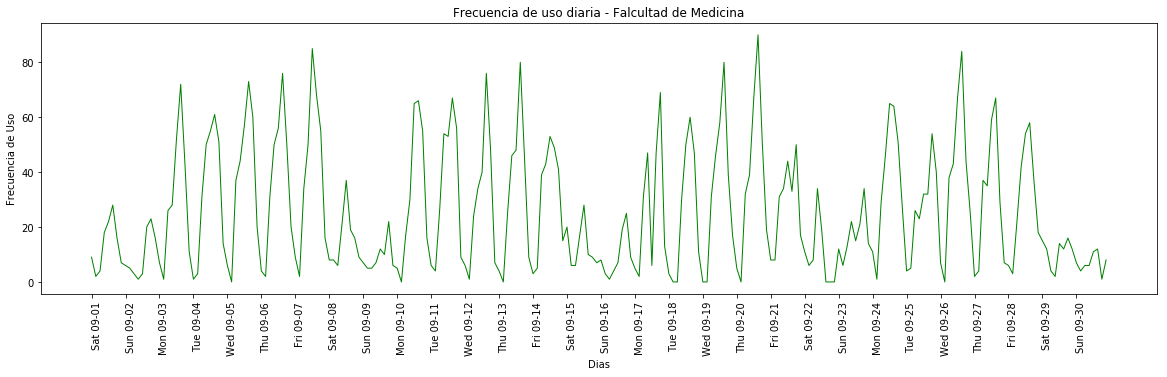

In [15]:
plt.figure(figsize=(20, 5))

#damos formato al eje x
xticks = pd.date_range(start=df_resampled.index.min(), end=df_resampled.index.max(), freq='D')
plt.xticks(xticks, xticks.strftime("%a %m-%d"), rotation=90, ha="left")

#definimos el plot
plt.plot(df_resampled, linewidth=1, color='g')

#agregamos información del gráfico
plt.title('Frecuencia de uso diaria - Falcultad de Medicina')
plt.xlabel("Dias")
plt.ylabel("Frecuencia de Uso");

Observamos un claro patrón donde se distinguen los fines de semana del resto de días.

## Trabajamos con el Modelo

In [50]:
# function to evaluate and plot a regressor on a given feature set
def eval_on_features(X_train, X_test, y_train, y_test, regressor):
     
    regressor.fit(X_train, y_train)
    
    print("Test-set R^2: {:.2f}".format(regressor.score(X_test, y_test)))
    
    y_pred = regressor.predict(X_test)
    y_pred_train = regressor.predict(X_train)
    n_train = len(y_train)
    

    
    plt.figure(figsize=(20,5))
    
    #plt.xticks(range(0, len(X), 25), xticks.strftime("%a %m-%d"), rotation=90, ha="left")
    
    plt.plot(range(len(y_train)), y_train, label="train",alpha=.3)
    plt.plot(range(n_train, len(y_test) + n_train), y_test, '-', label="test",alpha=.3)
    plt.plot(range(n_train), y_pred_train, '--', label="prediction train")
    plt.plot(range(n_train, len(y_test) + n_train), y_pred, '--', label="prediction test")
    
    plt.legend(loc=(1.01, 0))
    plt.xlabel("Fecha")
    plt.ylabel("Frecuencia de uso")

## Random Forest

In [34]:
#preparamos nuestro datos
y = df_resampled.values # extraemos los valores de conteo
X = np.hstack([np.array(df_resampled.index.dayofweek).reshape(-1,1),
               np.array(df_resampled.index.hour).reshape(-1,1)]) #recordando que nuestros datos corresponden a la hora

### Grid Search

In [35]:
param_grid = {'n_estimators': [ 1, 10, 100,1000], 'max_depth':[1,10,100,1000]}
print("Parameter grid:\n{}".format(param_grid))

Parameter grid:
{'n_estimators': [1, 10, 100, 1000], 'max_depth': [1, 10, 100, 1000]}


In [55]:
grid_search = GridSearchCV(RandomForestRegressor(n_jobs=-1), param_grid, cv=10, return_train_score=True)

In [56]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0)

In [57]:
grid_search.fit(X_train, y_train)

GridSearchCV(cv=10, error_score='raise-deprecating',
       estimator=RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators='warn', n_jobs=-1,
           oob_score=False, random_state=None, verbose=0, warm_start=False),
       fit_params=None, iid='warn', n_jobs=None,
       param_grid={'n_estimators': [1, 10, 100, 1000], 'max_depth': [1, 10, 100, 1000]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring=None, verbose=0)

In [58]:
print("Test set score: {:.2f}".format(grid_search.score(X_test, y_test)))

Test set score: 0.84


In [59]:
print("Best parameters: {}".format(grid_search.best_params_))
print("Best cross-validation score: {:.2f}".format(grid_search.best_score_))

Best parameters: {'max_depth': 1000, 'n_estimators': 10}
Best cross-validation score: 0.74


In [60]:
print("Best estimator:\n{}".format(grid_search.best_estimator_))

Best estimator:
RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=1000,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=-1,
           oob_score=False, random_state=None, verbose=0, warm_start=False)


In [64]:
# convert to DataFrame
results = pd.DataFrame(grid_search.cv_results_)
# show the first 5 rows
display(results.head(3))

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_max_depth,param_n_estimators,params,split0_test_score,split1_test_score,split2_test_score,...,split2_train_score,split3_train_score,split4_train_score,split5_train_score,split6_train_score,split7_train_score,split8_train_score,split9_train_score,mean_train_score,std_train_score
0,0.373289,0.493131,0.003384,0.004453,1,1,"{'max_depth': 1, 'n_estimators': 1}",0.286738,0.410304,0.067357,...,0.188800,0.304347,0.273233,0.281165,0.257461,0.259210,0.279398,0.282564,0.266644,0.028853
1,0.013929,0.005673,0.114736,0.005844,1,10,"{'max_depth': 1, 'n_estimators': 10}",0.254570,0.471105,0.279036,...,0.305281,0.319697,0.350357,0.328937,0.308605,0.285513,0.357488,0.351876,0.319473,0.025363
2,0.070469,0.008291,0.115605,0.004765,1,100,"{'max_depth': 1, 'n_estimators': 100}",0.328599,0.507655,0.333933,...,0.331239,0.330145,0.335994,0.329662,0.293401,0.324463,0.328146,0.348339,0.331425,0.015459


### Tomamos los mejores Párametros y Graficamos nuestro resultado

In [45]:
forest = RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=10, max_features='auto', max_leaf_nodes=None,
                               min_impurity_decrease=0.0, min_impurity_split=None, min_samples_leaf=1, min_samples_split=2,
                               min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=-1,
                               oob_score=False, random_state=None, verbose=0, warm_start=False)

Test-set R^2: 0.85


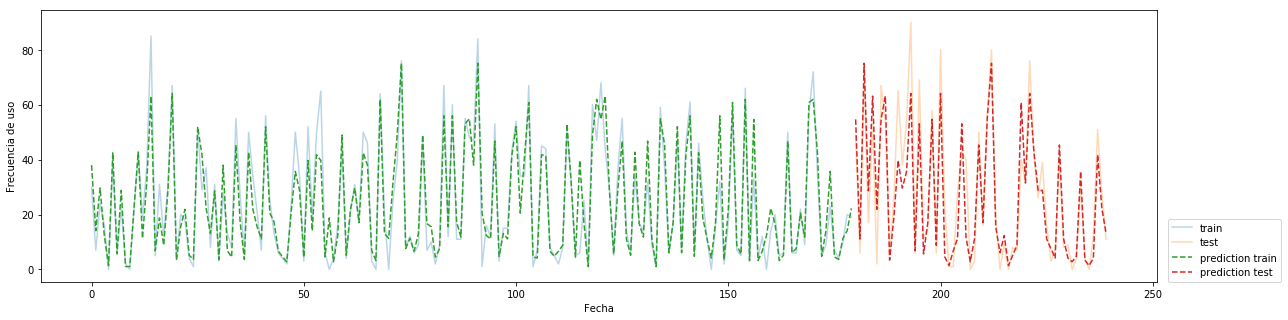

In [53]:
eval_on_features(X_train, X_test, y_train, y_test, forest) #llamamos nuestra función

### Agregamos el tiempo de uso

In [27]:
df = df[['origen_nombre','tiempo_uso(s)']]